In [133]:
import warnings
warnings.filterwarnings("ignore")

In [134]:
# Cell 1: Imports & Global Settings

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Estimator

# Notebook plotting style
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True

# CONFIG FLAGS 
USE_QUANTUM = True      # True = real quantum Estimator, False = fast classical approximation
QUANTUM_SHOTS = 128    # Number of shots for Estimator
RESERVOIR_DEPTH = 2    # EfficientSU2 repetitions
INPUT_FILE = "Train_Dataset_Simulated_Price_swaption.xlsx"  # colored sample file


In [135]:
# CELL 2 — Load data and melt tenor/maturity columns

def melt_swaption_file(input_file):
    print(" Loading:", input_file)
    
    df_raw = pd.read_excel(input_file, engine="openpyxl")
    
    # Identify columns containing Tenor/Maturity matrix
    grid_cols = [c for c in df_raw.columns if "Tenor" in str(c) and "Maturity" in str(c)]
    
    # Melt into long format
    df_long = df_raw.melt(
        id_vars=[c for c in df_raw.columns if c not in grid_cols],
        value_vars=grid_cols,
        var_name="Instrument",
        value_name="Price"
    )
    
    # Parse tenor/maturity numbers
    def parse_instrument(x):
        t = re.search(r"Tenor\s*:\s*([\d\.]+)", x)
        m = re.search(r"Maturity\s*:\s*([\d\.]+)", x)
        return float(t.group(1)), float(m.group(1))
    
    tenor_maturity = df_long["Instrument"].apply(parse_instrument)
    df_long["Tenor"] = tenor_maturity.apply(lambda x: x[0])
    df_long["Maturity"] = tenor_maturity.apply(lambda x: x[1])
    
    df_long.drop(columns=["Instrument"], inplace=True)
    
    return df_long

df = melt_swaption_file(INPUT_FILE)
df.head(5)


 Loading: Train_Dataset_Simulated_Price_swaption.xlsx


,Date,Price,Tenor,Maturity
0,2050-01-01,0.028565,1.0,0.083333
1,2050-01-02,0.029334,1.0,0.083333
2,2050-01-03,0.028696,1.0,0.083333
3,2050-01-05,0.030854,1.0,0.083333
4,2050-01-06,0.030406,1.0,0.083333


In [136]:
# CELL 3 — Feature engineering and dataset split

df["Date"] = pd.to_datetime(df["Date"])
df.sort_values("Date", inplace=True)

# numeric time encoding
df["Date_Ord"] = df["Date"].map(pd.Timestamp.toordinal)

# Features used in ML
FEATURES = ["Maturity", "Tenor", "Date_Ord"]
TARGET = "Price"

# Imputation = where price is NaN
impute_df = df[df["Price"].isna()].copy()
df_clean = df[df["Price"].notna()].copy()

# Forecast by date split (last 10%)
cut_idx = int(len(df_clean) * 0.9)
train_df = df_clean.iloc[:cut_idx]
forecast_df = df_clean.iloc[cut_idx:]

print("Train:", len(train_df))
print("Forecast:", len(forecast_df))
print("Impute:", len(impute_df))


Train: 99187
Forecast: 11021
Impute: 0


In [137]:
# CELL 4 — Scaling

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_x.fit_transform(train_df[FEATURES].values)
y_train = scaler_y.fit_transform(train_df[[TARGET]].values).ravel()

X_forecast = scaler_x.transform(forecast_df[FEATURES].values)

if len(impute_df) > 0:
    X_impute = scaler_x.transform(impute_df[FEATURES].values)
else:
    X_impute = None


In [138]:
# CELL 5 — Classical Ridge baseline

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

y_pred_ridge_scaled = ridge.predict(X_train)
y_pred_ridge_price = scaler_y.inverse_transform(
    y_pred_ridge_scaled.reshape(-1,1)
).ravel()

rmse_ridge = np.sqrt(mean_squared_error(train_df["Price"], y_pred_ridge_price))
mae_ridge = mean_absolute_error(train_df["Price"], y_pred_ridge_price)

print(" Classical Ridge:")
print("RMSE:", rmse_ridge)
print("MAE:", mae_ridge)


 Classical Ridge:
RMSE: 0.05966217151558002
MAE: 0.04923264939133062


In [139]:
# CELL 6 — Quantum Reservoir class

class QuantumReservoir:
    def __init__(self, n_qubits, depth=2, shots=256, use_quantum=True):
        self.nq = n_qubits
        self.depth = depth
        self.shots = shots
        self.use_quantum = use_quantum
        
        # Reservoir circuit
        circ = EfficientSU2(self.nq, reps=self.depth, entanglement='pairwise')
        params = np.random.uniform(0,2*np.pi,circ.num_parameters)
        circ.assign_parameters(params, inplace=True)
        self.circuit = circ
        
        # Observables (Z on each qubit)
        self.obs = [SparsePauliOp("".join("Z" if i==j else "I" for i in range(self.nq)))
                    for j in range(self.nq)]
        
        self.estimator = Estimator() if self.use_quantum else None
        self.readout = Ridge(alpha=0.5)
    
    def transform(self, X):
        feats = []
        for x in X:
            if self.use_quantum:
                qc = QuantumCircuit(self.nq)
                for qi,v in enumerate(x):
                    qc.ry(np.pi*v, qi)
                qc.compose(self.circuit, inplace=True)
                
                exps = []
                for o in self.obs:
                    res = self.estimator.run(qc, o, shots=self.shots).result()
                    exps.append(res.values[0])
                feats.append(exps)
            else:
                feats.append([np.sin(v*(i+1)) for i,v in enumerate(x)])
        return np.array(feats)
    
    def fit(self, X, y):
        Z = self.transform(X)
        self.readout.fit(Z, y)
    
    def predict(self, X):
        Z = self.transform(X)
        return self.readout.predict(Z)


In [140]:
# CELL 7 — Quantum Reservoir on a SMALL SUBSET (for true QML demo)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# How many samples to use for the quantum model
N_Q = 200   # can try 200–400, but 200 will be much faster

qrc = QuantumReservoir(
    n_qubits=len(FEATURES),
    depth=RESERVOIR_DEPTH,
    shots=QUANTUM_SHOTS,
    use_quantum=True
)

# Subset of training data for quantum
X_train_q = X_train[:N_Q]
y_train_q = y_train[:N_Q]
prices_train_q = train_df["Price"].values[:N_Q]

print(f" Training Quantum Reservoir on {N_Q} samples...")
qrc.fit(X_train_q, y_train_q)

print(" Evaluating on the SAME subset...")

# Quantum predictions (subset only)
y_q_pred_scaled = qrc.predict(X_train_q)
y_q_pred_price = scaler_y.inverse_transform(
    y_q_pred_scaled.reshape(-1, 1)
).ravel()

rmse_q = np.sqrt(mean_squared_error(prices_train_q, y_q_pred_price))
mae_q = mean_absolute_error(prices_train_q, y_q_pred_price)

# Classical baseline on SAME subset
y_ridge_sub_price = y_pred_ridge_price[:N_Q]
rmse_ridge_sub = np.sqrt(mean_squared_error(prices_train_q, y_ridge_sub_price))
mae_ridge_sub = mean_absolute_error(prices_train_q, y_ridge_sub_price)

print("\n Classical Ridge on subset:")
print(f"  RMSE: {rmse_ridge_sub:.6f}")
print(f"  MAE : {mae_ridge_sub:.6f}")

print("\n Quantum Reservoir on subset:")
print(f"  RMSE: {rmse_q:.6f}")
print(f"  MAE : {mae_q:.6f}")


 Training Quantum Reservoir on 200 samples...
 Evaluating on the SAME subset...

 Classical Ridge on subset:
  RMSE: 0.052955
  MAE : 0.043884

 Quantum Reservoir on subset:
  RMSE: 0.055652
  MAE : 0.045514


In [141]:
# CELL 8 — Hybrid model

Z_train = qrc.transform(X_train_q)
X_hybrid = np.hstack([X_train_q, Z_train])

ridge_h = Ridge(alpha=0.5)
ridge_h.fit(X_hybrid, y_train_q)
pred_h_scaled = ridge_h.predict(X_hybrid)
pred_h_price = scaler_y.inverse_transform(pred_h_scaled.reshape(-1,1)).ravel()

rmse_h = np.sqrt(mean_squared_error(train_df["Price"][:N_Q], pred_h_price))
mae_h = mean_absolute_error(train_df["Price"][:N_Q], pred_h_price)

pd.DataFrame({
    "Model": ["Classical", "Quantum-Only", "Hybrid"],
    "RMSE":  [rmse_ridge, rmse_q, rmse_h],
    "MAE":   [mae_ridge, mae_q, mae_h]
})


,Model,RMSE,MAE
0,Classical,0.059662,0.049233
1,Quantum-Only,0.055652,0.045514
2,Hybrid,0.045081,0.037277


In [142]:
# CELL 9 — Imputation & Forecast using CLASSICAL model (fast & scalable)

print(" Generating imputation & forecast with classical Ridge model...")

# Impute where Price was NaN (if any)
if X_impute is not None:
    impute_pred_scaled = ridge.predict(X_impute)
    impute_pred_price = scaler_y.inverse_transform(
        impute_pred_scaled.reshape(-1, 1)
    ).ravel()
    
    impute_results = impute_df.copy()
    impute_results["Predicted_Price"] = impute_pred_price
    impute_results.to_csv("Final_Imputation_Results.csv", index=False)
    print(" Saved Final_Imputation_Results.csv")
else:
    impute_results = None
    print(" No imputation rows (no NaN prices). Skipping imputation CSV.")

# Forecast on last 10% of clean data
forecast_pred_scaled = ridge.predict(X_forecast)
forecast_pred_price = scaler_y.inverse_transform(
    forecast_pred_scaled.reshape(-1, 1)
).ravel()

forecast_results = forecast_df.copy()
forecast_results["Predicted_Price"] = forecast_pred_price
forecast_results.to_csv("Final_Forecast_Results.csv", index=False)
print(" Saved Final_Forecast_Results.csv")


 Generating imputation & forecast with classical Ridge model...
 No imputation rows (no NaN prices). Skipping imputation CSV.
 Saved Final_Forecast_Results.csv


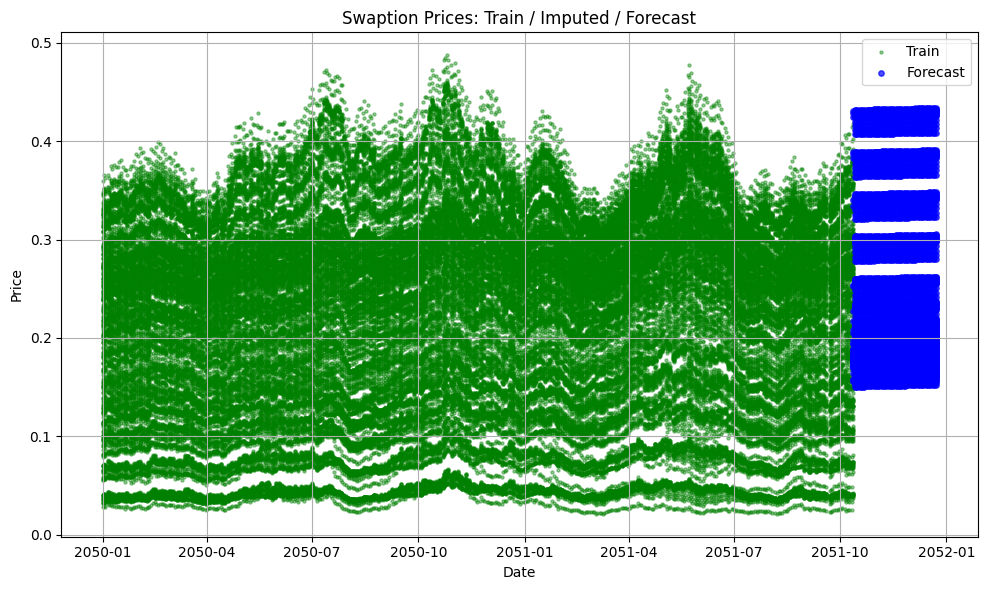

In [143]:
# CELL 10 — Visualization

plt.scatter(
    train_df["Date"], train_df["Price"],
    s=5, c="green", alpha=0.4, label="Train"
)

plt.scatter(
    forecast_results["Date"], forecast_results["Predicted_Price"],
    s=15, c="blue", alpha=0.7, label="Forecast"
)

if impute_results is not None:
    plt.scatter(
        impute_results["Date"], impute_results["Predicted_Price"],
        s=15, c="purple", alpha=0.7, marker="x", label="Imputed"
    )

plt.title("Swaption Prices: Train / Imputed / Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()
